# Model Training & Testing

In [121]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# attribute = "shape"
attribute = "fill"
# attribute = "colour"
model_name = f"{attribute}_model.tflite"

data_dir = pathlib.Path(f"./training_sets/group2/{attribute}")


In [122]:
batch_size = 32
img_height = 180
img_width = 180

In [123]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 271 files belonging to 3 classes.
Using 217 files for training.


In [124]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 271 files belonging to 3 classes.
Using 54 files for validation.


In [125]:
class_names = train_ds.class_names
print(class_names)

['hollow', 'shaded', 'solid']


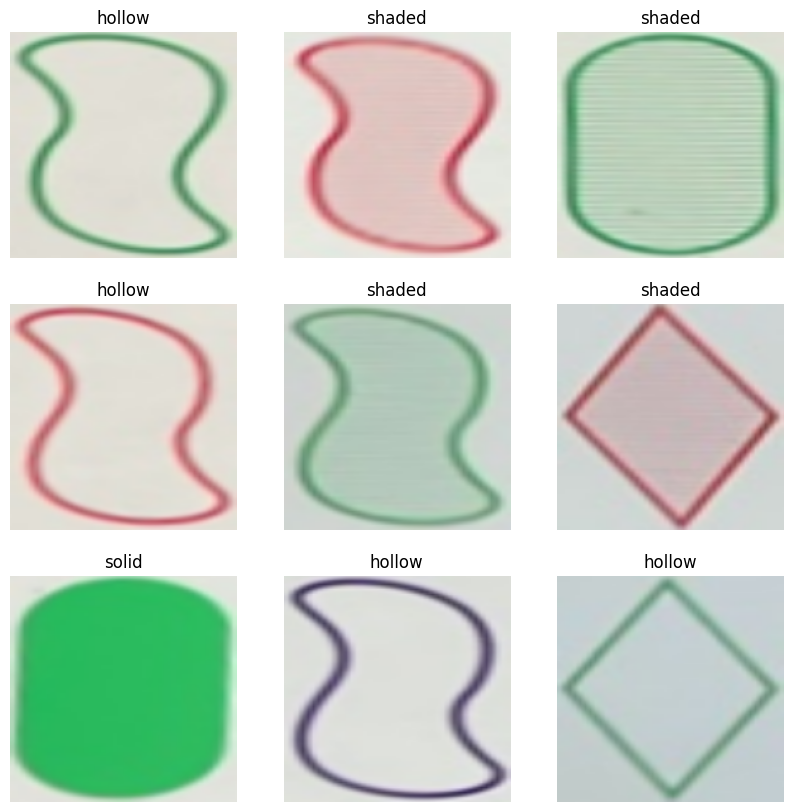

In [126]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [127]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [128]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [129]:
normalization_layer = layers.Rescaling(1./255)

In [130]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.3108715 0.8948148


# Create the model

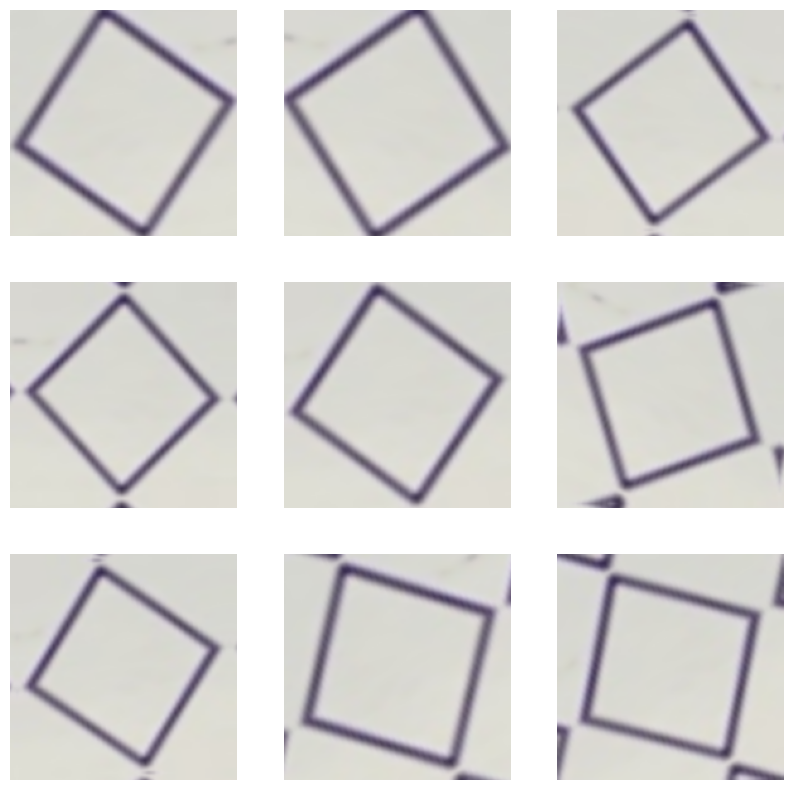

In [131]:
# Data Augmentation 

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [132]:
# Create the model

num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [133]:
# Compile it.

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [134]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_10 (Sequential)  (None, 180, 180, 3)       0         
                                                                 
 rescaling_11 (Rescaling)    (None, 180, 180, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPooli  (None, 90, 90, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_16 (Conv2D)          (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_16 (MaxPooli  (None, 45, 45, 32)        0         
 ng2D)                                               

In [135]:
# Train it.

epochs = 15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/15


7/7 [==============================] - 1s 155ms/step - loss: 1.3019 - accuracy: 0.3226 - val_loss: 1.0979 - val_accuracy: 0.2407
Epoch 2/15
7/7 [==============================] - 1s 136ms/step - loss: 0.8714 - accuracy: 0.4793 - val_loss: 0.8564 - val_accuracy: 0.5556
Epoch 3/15
7/7 [==============================] - 1s 134ms/step - loss: 0.7113 - accuracy: 0.6866 - val_loss: 0.8091 - val_accuracy: 0.5741
Epoch 4/15
7/7 [==============================] - 1s 139ms/step - loss: 0.6358 - accuracy: 0.7235 - val_loss: 0.6978 - val_accuracy: 0.5926
Epoch 5/15
7/7 [==============================] - 1s 134ms/step - loss: 0.5067 - accuracy: 0.7604 - val_loss: 0.5164 - val_accuracy: 0.6667
Epoch 6/15
7/7 [==============================] - 1s 156ms/step - loss: 0.4422 - accuracy: 0.7373 - val_loss: 0.4024 - val_accuracy: 0.8148
Epoch 7/15
7/7 [==============================] - 1s 135ms/step - loss: 0.4385 - accuracy: 0.7558 - val_loss: 0.4892 - val_accuracy: 0.6852
Epoch 8/15
7/7 [===============

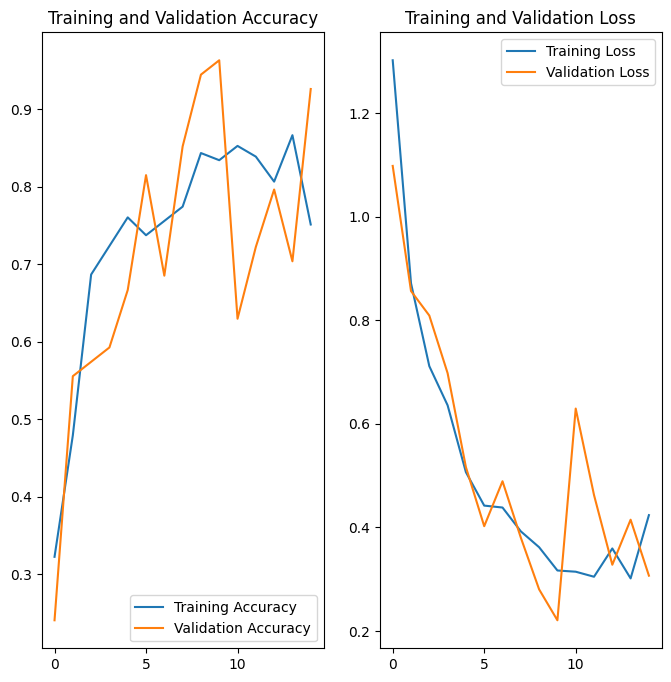

In [136]:
# Display results

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [137]:
# Predicting new data


# unseen_dir = pathlib.Path("./training_sets/unseen-cards/card_1_7.png")
unseen_dir = pathlib.Path("./training_sets/group2/fill/shaded/shape_11.png")

img = tf.keras.utils.load_img(
    unseen_dir, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 40ms/step
This image most likely belongs to shaded with a 59.01 percent confidence.


In [138]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(model_name, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /var/folders/_t/n4kvyq1d29x5wsk8s1grbhth0000gn/T/tmp3wglgchp/assets


INFO:tensorflow:Assets written to: /var/folders/_t/n4kvyq1d29x5wsk8s1grbhth0000gn/T/tmp3wglgchp/assets
2024-06-23 12:11:03.385484: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-06-23 12:11:03.385500: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
2024-06-23 12:11:03.385627: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /var/folders/_t/n4kvyq1d29x5wsk8s1grbhth0000gn/T/tmp3wglgchp
2024-06-23 12:11:03.387388: I tensorflow/cc/saved_model/reader.cc:51] Reading meta graph with tags { serve }
2024-06-23 12:11:03.387394: I tensorflow/cc/saved_model/reader.cc:146] Reading SavedModel debug info (if present) from: /var/folders/_t/n4kvyq1d29x5wsk8s1grbhth0000gn/T/tmp3wglgchp
2024-06-23 12:11:03.392074: I tensorflow/cc/saved_model/loader.cc:233] Restoring SavedModel bundle.
2024-06-23 12:11:03.481429: I tensorflow/cc/saved_model/loader.cc:217] Running initialization

In [139]:
# Try load and use the model

TF_MODEL_FILE_PATH = model_name 

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_10_input'],
  'outputs': ['outputs']}}

In [140]:
classify_lite = interpreter.get_signature_runner('serving_default')

In [141]:
print(classify_lite)

predictions_lite = classify_lite(sequential_10_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

In [142]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

This image most likely belongs to shaded with a 59.01 percent confidence.
